<a href="https://colab.research.google.com/github/rajatshah2006/AILMLCourseNoteBook/blob/main/NLPChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>
<center><font size=8>NLP Chatboat</center></font>

<br><br>


# Problem Statement
##### **DOMAIN:**
Industrial safety. NLP based Chatbot.
##### **CONTEXT:**
The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.
##### **DATA DESCRIPTION:**
This  The  database  is  basically  records  of  accidents  from 12  different  plants  in  03  different  countries which  every  line  in  the  data  is  an occurrence of an accident.

**Columns description:**
- `Data:` timestamp or time/date information
- `Countries:` which country the accident occurred (anonymised)
- `Local:` the city where the manufacturing plant is located (anonymised)
- `Industry sector:` which sector the plant belongs to
- `Accident level:` from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
- `Potential Accident Level:` Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
- `Genre:` if the person is male of female
- `Employee or Third Party:` if the injured person is an employee or a third party
- `Critical Risk:` some description of the risk involved in the accident
- `Description:` Detailed description of how the accident happened.

Link to download the dataset: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database [ for your reference only ]
##### **PROJECT OBJECTIVE:**
Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident
description.

# **Installing and Importing Necessary Libraries**

In [5]:
  # Connect Google Drive : Rajat

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.6 MB/s eta 0:00:00


In [7]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


import zipfile as zf
import pandas as pd
import numpy as np
import datetime as dt
import re
import string
import spacy

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from gensim.models import Word2Vec

import unicodedata
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Loading the dataset**

In [9]:
data=pd.read_excel("/content/drive/MyDrive/AIMLCourse/CapstoneProject/DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx")
#data=pd.read_excel("Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx")


In [10]:
data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 36.7+ KB


**Observations:**
- There is one column having index value for rows
- There is one datetime column named 'Data', which should be renamed to 'Date'
- There are 9 column which are of object time. Out of which other than 'Description' column other columns can be converted to Categorical type
- No null value found

In [12]:
data.shape

(425, 11)

**Observation:**
- There are 425 rows and 11 columns

# Data cleansing

##### Check for null values


In [13]:
data.isna().sum()

,0
Unnamed: 0,0
Data,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Genre,0
Employee or Third Party,0
Critical Risk,0


**Observation:**
- There are no null values

Dropping "Unnamed: 0" column

In [14]:
data.drop("Unnamed: 0", axis=1, inplace=True)

##### Check for duplicate values


In [15]:
# Check duplicate counts
duplicate_counts = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_counts}")

Number of duplicate rows: 7


In [16]:
# Get all duplicate rows (including the first occurrence)
duplicate_rows = data[data.duplicated(keep=False)]

# Sort by index to group original and duplicates together
duplicate_rows = duplicate_rows.sort_values(by=duplicate_rows.columns.tolist())

# Display the duplicate rows
print("Original and Duplicate Rows:")
display(duplicate_rows)

Original and Duplicate Rows:


,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
76,2016-04-01,Country_01,Local_01,Mining,I,V,Male,Third Party (Remote),Others,In circumstances that two workers of the Abrat...
77,2016-04-01,Country_01,Local_01,Mining,I,V,Male,Third Party (Remote),Others,In circumstances that two workers of the Abrat...
261,2016-12-01,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
262,2016-12-01,Country_01,Local_03,Mining,I,IV,Male,Employee,Others,During the activity of chuteo of ore in hopper...
302,2017-01-21,Country_02,Local_02,Mining,I,I,Male,Third Party (Remote),Others,Employees engaged in the removal of material f...
303,2017-01-21,Country_02,Local_02,Mining,I,I,Male,Third Party (Remote),Others,Employees engaged in the removal of material f...
344,2017-03-02,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
345,2017-03-02,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
346,2017-03-02,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,On 02/03/17 during the soil sampling in the re...
354,2017-03-15,Country_03,Local_10,Others,I,I,Male,Third Party,Venomous Animals,Team of the VMS Project performed soil collect...


In [17]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [18]:
data.duplicated().sum()

0

Renaming columns

In [19]:
# Renaming the columns appropriately
data.rename(columns={'Data':'Date', 'Countries':'Country', 'Local':'City', 'Genre':'Gender', 'Employee or Third Party':'Employee Type'}, inplace=True)

In [20]:
# Extracting year & month from 'Data' column
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day_name()

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      418 non-null    datetime64[ns]
 1   Country                   418 non-null    object        
 2   City                      418 non-null    object        
 3   Industry Sector           418 non-null    object        
 4   Accident Level            418 non-null    object        
 5   Potential Accident Level  418 non-null    object        
 6   Gender                    418 non-null    object        
 7   Employee Type             418 non-null    object        
 8   Critical Risk             418 non-null    object        
 9   Description               418 non-null    object        
 10  Year                      418 non-null    int32         
 11  Month                     418 non-null    int32         
 12  Day                   

In [22]:
data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,Friday
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,Saturday
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,Wednesday
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,Friday
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,Sunday


In [23]:
#Check for unique values in each column

for col in data.columns[:-4]:
  print(f"Unique values in column '{col}': {data[col].unique()}")
  print(f"Number of unique values in column '{col}': {data[col].nunique()}")
  print("-" * 20)


Unique values in column 'Date': <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-06 00:00:00',
 '2016-01-08 00:00:00', '2016-01-10 00:00:00', '2016-01-12 00:00:00',
 '2016-01-16 00:00:00', '2016-01-17 00:00:00', '2016-01-19 00:00:00',
 '2016-01-26 00:00:00',
 ...
 '2017-06-24 00:00:00', '2017-06-20 00:00:00', '2017-06-23 00:00:00',
 '2017-06-19 00:00:00', '2017-06-22 00:00:00', '2017-06-29 00:00:00',
 '2017-07-04 00:00:00', '2017-07-05 00:00:00', '2017-07-06 00:00:00',
 '2017-07-09 00:00:00']
Length: 287, dtype: datetime64[ns]
Number of unique values in column 'Date': 287
--------------------
Unique values in column 'Country': ['Country_01' 'Country_02' 'Country_03']
Number of unique values in column 'Country': 3
--------------------
Unique values in column 'City': ['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
Number of unique values in column 'City': 12
--------------------


**Observation:**
- There \n Not applicable values in critical rik column

In [24]:
data[data['Critical Risk']=='\nNot applicable'].head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
153,2016-06-17,Country_02,Local_08,Metals,IV,V,Male,Employee,\nNot applicable,"At approximately 5:45 pm, the operator Paulo (...",2016,6,Friday


In [25]:
#  Replace \n Not applicable with Not applicable in critical Risk colunn

data['Critical Risk'] = data['Critical Risk'].replace('\nNot applicable', 'Not applicable')



In [26]:
#Check for unique values in each column

for col in data.columns[:-4]:
  print(f"Unique values in column '{col}': {data[col].unique()}")
  print(f"Number of unique values in column '{col}': {data[col].nunique()}")
  print("-" * 20)

Unique values in column 'Date': <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-06 00:00:00',
 '2016-01-08 00:00:00', '2016-01-10 00:00:00', '2016-01-12 00:00:00',
 '2016-01-16 00:00:00', '2016-01-17 00:00:00', '2016-01-19 00:00:00',
 '2016-01-26 00:00:00',
 ...
 '2017-06-24 00:00:00', '2017-06-20 00:00:00', '2017-06-23 00:00:00',
 '2017-06-19 00:00:00', '2017-06-22 00:00:00', '2017-06-29 00:00:00',
 '2017-07-04 00:00:00', '2017-07-05 00:00:00', '2017-07-06 00:00:00',
 '2017-07-09 00:00:00']
Length: 287, dtype: datetime64[ns]
Number of unique values in column 'Date': 287
--------------------
Unique values in column 'Country': ['Country_01' 'Country_02' 'Country_03']
Number of unique values in column 'Country': 3
--------------------
Unique values in column 'City': ['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
Number of unique values in column 'City': 12
--------------------


# Exploratory Data Analysis

## Univariate Analysis

In [27]:
# function to plot a pie chart for a perticular column

def plot_pie_chart(df, column_name,chartname):
    """Plots a pie chart for the specified column in the dataframe.

    Args:
        df: The pandas DataFrame.
        column_name: The name of the column to plot.
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    value_counts = df[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(chartname)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


#### Distribution of Year Column

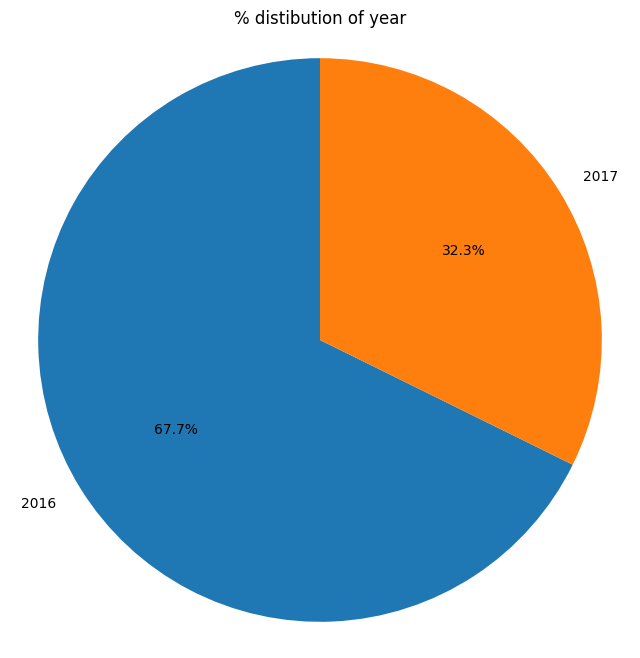

In [28]:
plot_pie_chart(data,'Year',"% distibution of year")

**Observation:**
-  Injuries seems to be higher in 2016 as compared to 2017

#### Distribution of Industry Sector  

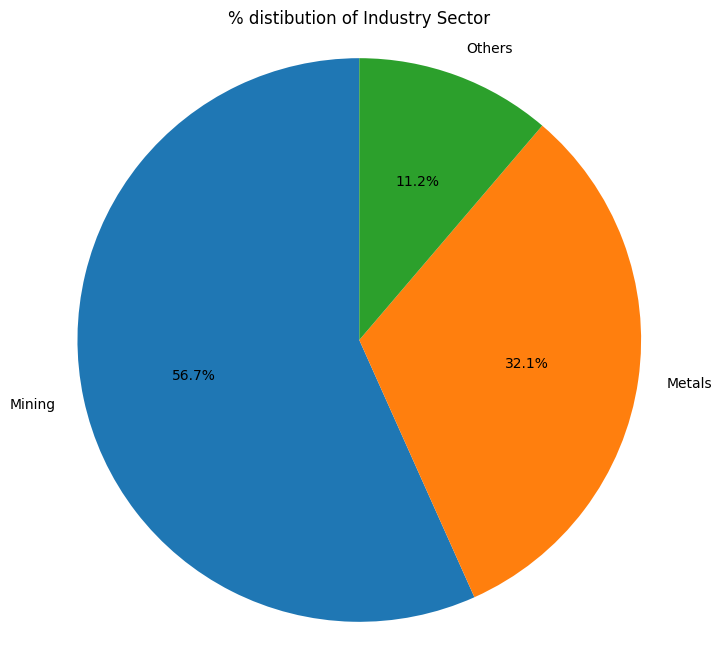

In [29]:
plot_pie_chart(data,'Industry Sector',"% distibution of Industry Sector")

**Observation:**
- Mining have most number of injuries followed by Metals and then we have other industries

#### Distribution of Country

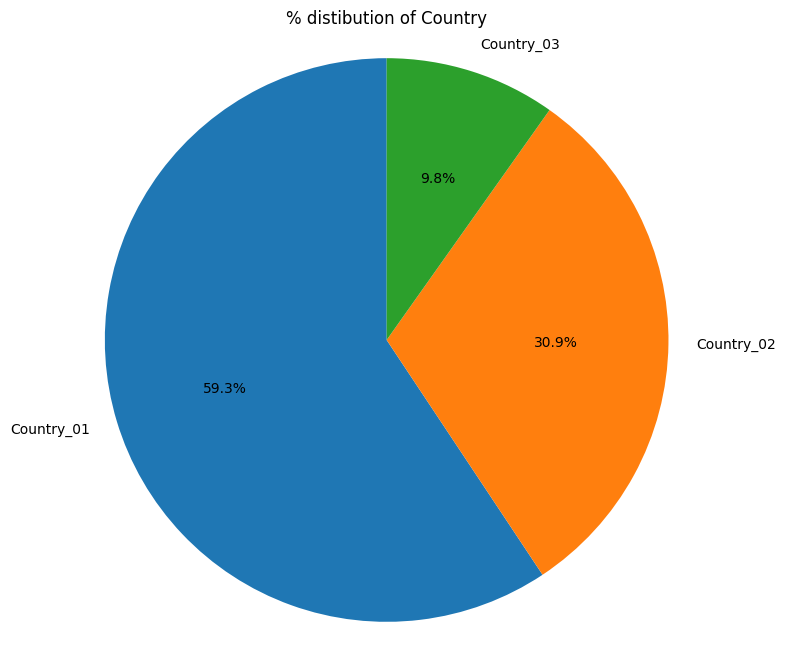

In [30]:
plot_pie_chart(data,'Country',"% distibution of Country")

**Observation:**
- Country_01 witnesses the highest number of accidents, followed by Country02, which together contribute to ~90% of the total accidents.

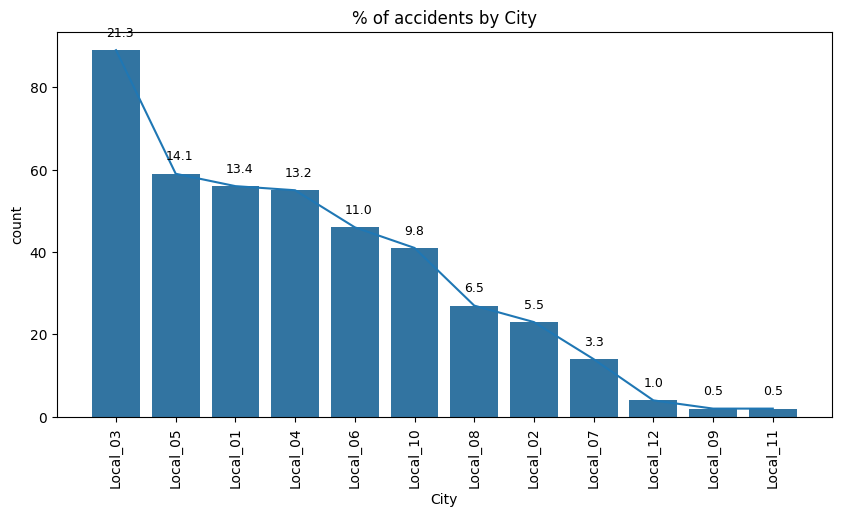

In [31]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data, x='City', order=data['City'].value_counts().index)
sns.lineplot(data['City'].value_counts().values)
plt.xticks(rotation=90)
total = sum(data['City'].value_counts())
for p in ax.patches:
    ax.annotate('{:.1f}'.format(100 * p.get_height() / total),
                (p.get_x(), p.get_height()), size=9, xytext=(10, 10), textcoords='offset points')
plt.title('% of accidents by City')
plt.show()


**Observation:**
- About 61% of the accidents together occur in plants located in Local_01, Local_03, Local_04 & Local_05 cities, of which Local_03 alone has recorded 21% accidents. Another 21% accidents are recorded by Local_06 & Local_10 cities. The bottom most 6 cities - Local_02, Local_07, Local_08, Local_09, Local_11, Local_12 cities witnessed only 17% of the accidents.

#### Distribution of Gender

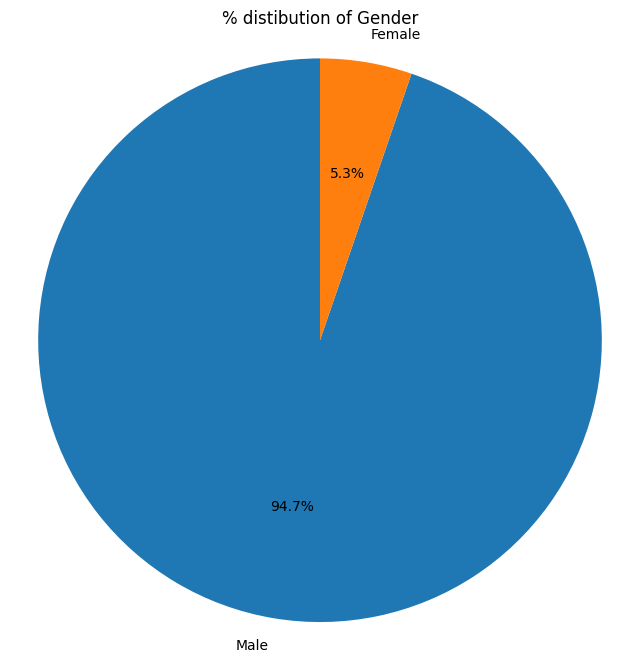

In [32]:
plot_pie_chart(data,'Gender',"% distibution of Gender")

**Observation:**
 - We can see the only ~5% Females have encountered accidents. This could be due to a general assumption of majority of industrial jobs being taken up by Males.

#### Distribution of Employee Type

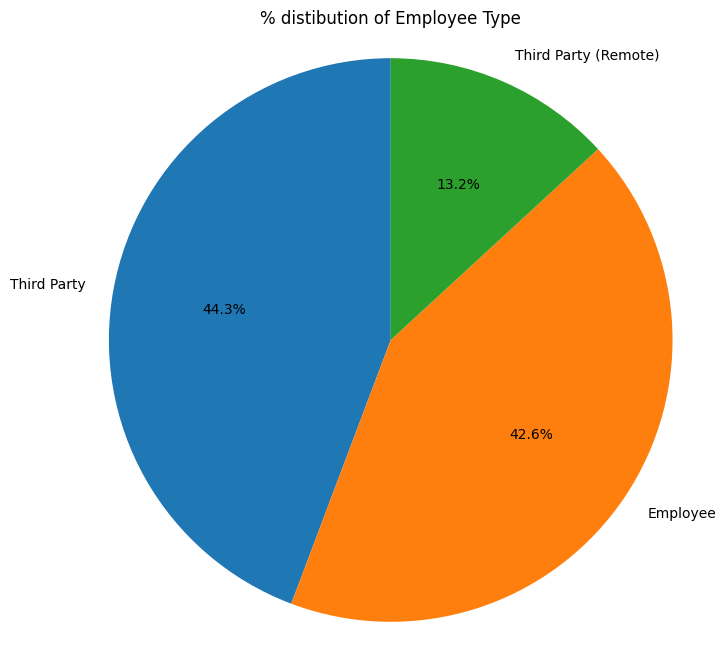

In [33]:
plot_pie_chart(data,'Employee Type',"% distibution of Employee Type")

**Observation:**
 - The minimum accidents are faced by the Third Party Remote workers as they are not always working on the sites. Overall 58% of the accidents are encountered Third Party employees.

Distribution of Critical Risk

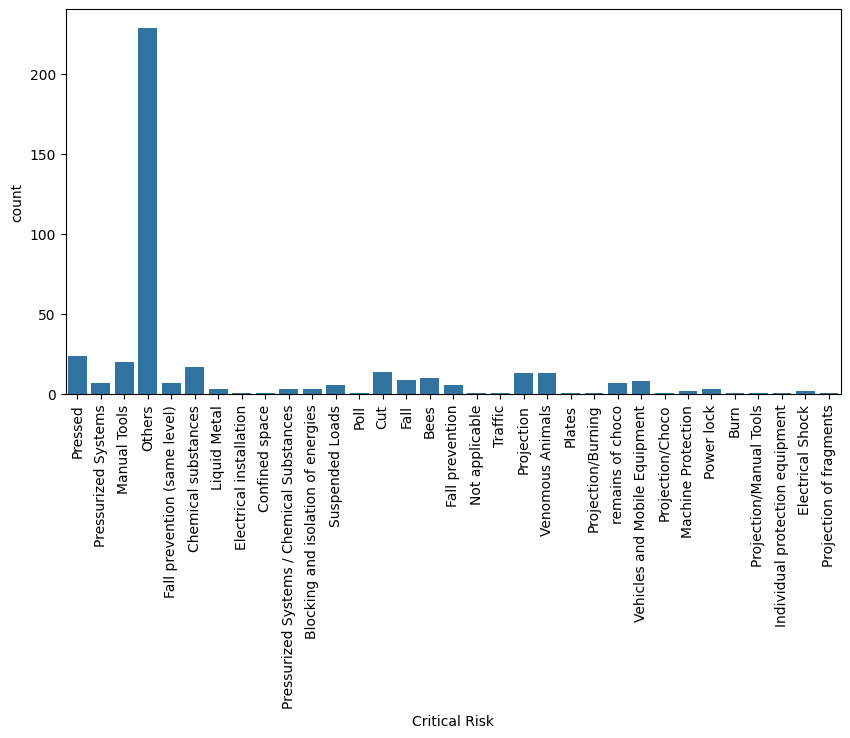

In [34]:
plt.figure(figsize=(10, 5))
sns.countplot(data, x='Critical Risk')
plt.xticks(rotation=90)
plt.show()

**Observation**
- Most of the Risk is Other which is 50% of data set
- The common risks are Pressed , Manual Tools , Chemical substances, Cut , Venomous Animals

##### DIstribution of Accident Level

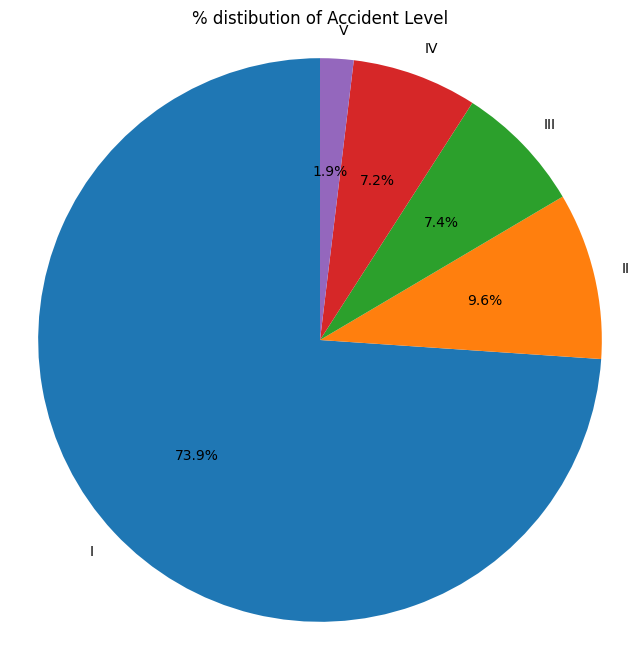

In [35]:
plot_pie_chart(data,'Accident Level',"% distibution of Accident Level")

**Observation:**
- Accident level I is most which means not severe
- Accident level I is followed by II, III, IV and V


#### Distribution of Potential Accident Level

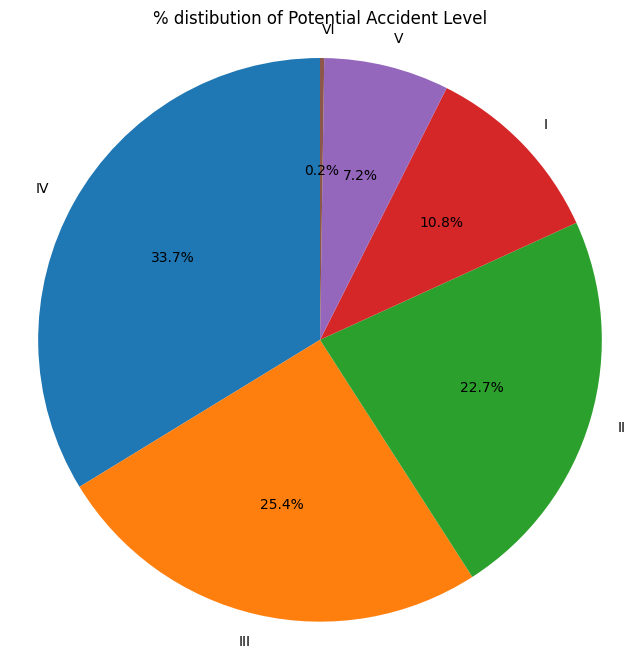

In [36]:
plot_pie_chart(data,'Potential Accident Level',"% distibution of Potential Accident Level")

**Observation:**
- Potential Accident Level: 81% accidents could potentially be moderately severe onces. and only 7.5% could've potentially been the most severe ones

- Potential Accident Level differs from the Accident Level. Majority are Level I accidents wheareas potential accidents have a majority in moderately severe ones (Level II, III & IV together).

## Multivariate Analysis

#### Accident level vs Potential Accident level

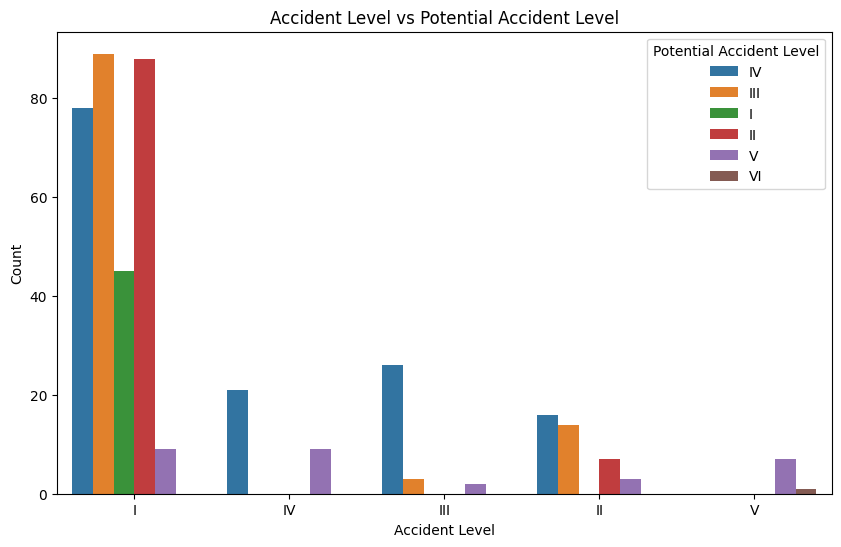

Correlation between Accident Level and Potential Accident Level: 0.5094221676464207

Cross-tabulation of Accident Level vs Potential Accident Level:


Potential Accident Level,I,II,III,IV,V,VI
Accident Level,,,,,,
I,45,88,89,78,9,0
II,0,7,14,16,3,0
III,0,0,3,26,2,0
IV,0,0,0,21,9,0
V,0,0,0,0,7,1


In [37]:
# Accident level vs Potential Accident level

df=data.copy()
plt.figure(figsize=(10, 6))
sns.countplot(x='Accident Level', hue='Potential Accident Level', data=df)
plt.title('Accident Level vs Potential Accident Level')
plt.xlabel('Accident Level')
plt.ylabel('Count')
plt.show()

# Calculate the correlation between Accident Level and Potential Accident Level (if numerical representation is available)
# If 'Accident Level' and 'Potential Accident Level' are categorical, convert them to numerical for correlation
# Example using Label Encoding (you might need a different approach based on your data)
label_encoder = LabelEncoder()
df['Accident Level Encoded'] = label_encoder.fit_transform(data['Accident Level'])
df['Potential Accident Level Encoded'] = label_encoder.fit_transform(data['Potential Accident Level'])

correlation = df['Accident Level Encoded'].corr(df['Potential Accident Level Encoded'])
print(f"Correlation between Accident Level and Potential Accident Level: {correlation}")


# Create a cross-tabulation to see the frequency of each combination
cross_tab = pd.crosstab(df['Accident Level'], df['Potential Accident Level'])
print("\nCross-tabulation of Accident Level vs Potential Accident Level:")
cross_tab


**Observation:**
- There is 50% correlation between accideent level and Potential Accident Level

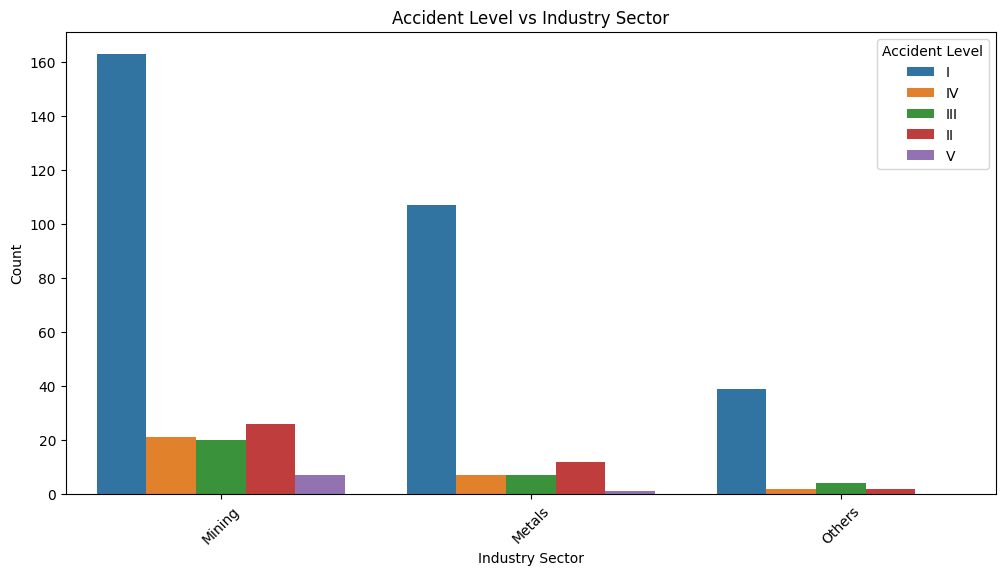

Accident Level,I,II,III,IV,V
Industry Sector,,,,,
Metals,107,12,7,7,1
Mining,163,26,20,21,7
Others,39,2,4,2,0


In [38]:
# industry vs Accident level

# Accident Level vs Industry Sector
plt.figure(figsize=(12, 6))
sns.countplot(x='Industry Sector', hue='Accident Level', data=data)
plt.title('Accident Level vs Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Calculate the correlation if numerical representation is available
# If categorical, consider using Cramer's V or Theil's U for association

# Industry vs Accident Level contingency table
industry_accident_level = pd.crosstab(data['Industry Sector'], data['Accident Level'])
industry_accident_level


**Observation:**
- Mining industry has most number of accidents and also similar proposition observed with accident level
- Metals and others have mostly level I accident
- Metails have more level II accidents while others have more III level followed by level I

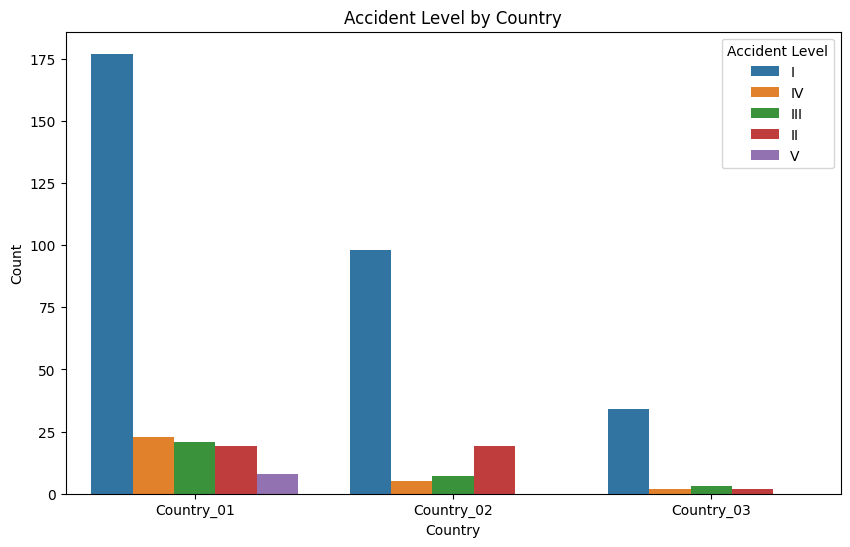

Accident Level         I        II       III        IV         V
Country                                                         
Country_01      0.713710  0.076613  0.084677  0.092742  0.032258
Country_02      0.759690  0.147287  0.054264  0.038760       NaN
Country_03      0.829268  0.048780  0.073171  0.048780       NaN


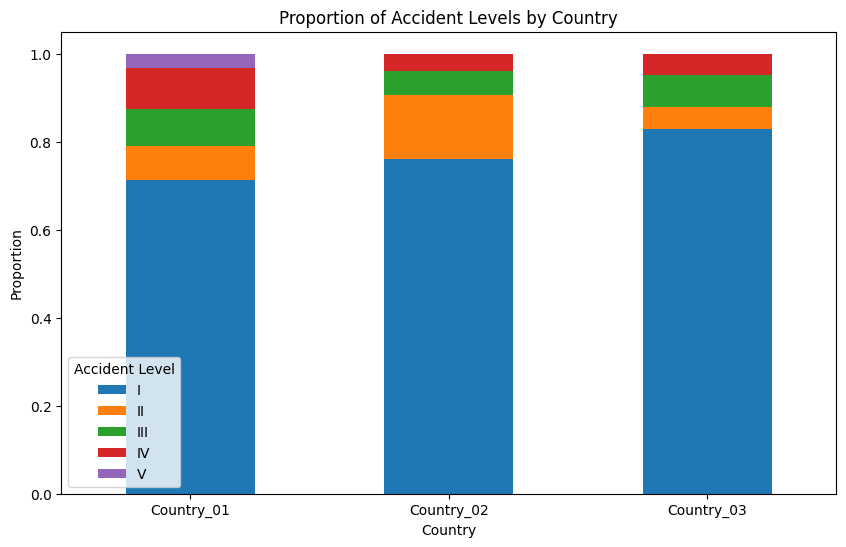

In [39]:
# Accident level by COuntry

# Accident level by country
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', hue='Accident Level', data=data)
plt.title('Accident Level by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Calculate accident level proportions for each country
accident_level_by_country = data.groupby('Country')['Accident Level'].value_counts(normalize=True).unstack()
print(accident_level_by_country)

# Optional: Visualize the proportions
accident_level_by_country.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Accident Levels by Country')
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Accident Level')
plt.show()


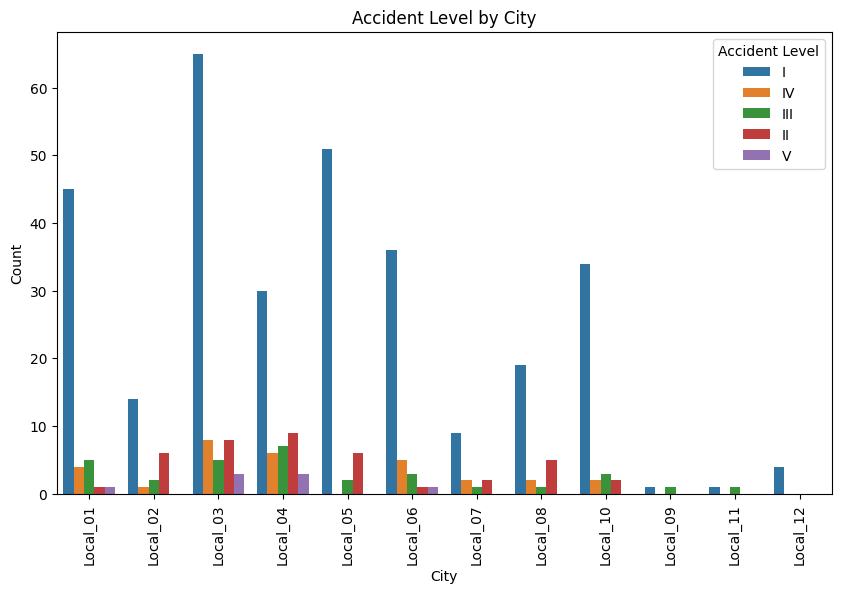

In [40]:
# prompt: Accident level by city

# Accident level by city
plt.figure(figsize=(10, 6))
sns.countplot(x='City', hue='Accident Level', data=data)
plt.title('Accident Level by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


## Data Preprocessing

In [41]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Remove special characters

In [42]:
#method to clean up special characters from data

import re

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [43]:
#Apply cleaning text for all rows


def process_news(text):
    cleaned_text = clean_text(text)
    return cleaned_text

df['Cleaned_Description'] = df['Description'].apply(process_news)



In [44]:
print(df[['Description', 'Cleaned_Description']].head())

                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 Cleaned_Description  
0  while removing the drill rod of the jumbo for ...  
1  during the activation of a sodium sulphide pum...  
2  in the substation milpo located at level when ...  
3  being am approximately in the nv cx ob the per...  
4  approximately at am in circumstances that the ...  


### Lowercase the news data

In [45]:
#lowercase the cleaned description

df['Cleaned_Description'] = df['Cleaned_Description'].str.lower()
print(df[['Description', 'Cleaned_Description']].head())


                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 Cleaned_Description  
0  while removing the drill rod of the jumbo for ...  
1  during the activation of a sodium sulphide pum...  
2  in the substation milpo located at level when ...  
3  being am approximately in the nv cx ob the per...  
4  approximately at am in circumstances that the ...  


### Remove Whitespaces

In [46]:
df['Cleaned_Description'] = df['Cleaned_Description'].str.strip()
print(df[['Description', 'Cleaned_Description']].head())

                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 Cleaned_Description  
0  while removing the drill rod of the jumbo for ...  
1  during the activation of a sodium sulphide pum...  
2  in the substation milpo located at level when ...  
3  being am approximately in the nv cx ob the per...  
4  approximately at am in circumstances that the ...  


### Remove Stopwords

In [47]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords
    clean_text= ' '.join([word for word in tokens if word not in stopwords.words('english')])
    return clean_text

In [49]:
df['Cleaned_Description']=df['Cleaned_Description'].apply(remove_stopwords)
print(df[['Description', 'Cleaned_Description']].head())

                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 Cleaned_Description  
0  removing drill rod jumbo maintenance superviso...  
1  activation sodium sulphide pump piping uncoupl...  
2  substation milpo located level collaborator ex...  
3  approximately nv cx ob personnel begins task u...  
4  approximately circumstances mechanics anthony ...  


### Stemming

In [50]:
ps = nltk.PorterStemmer()

def stem_words(text):
    # Tokenize the text
    tokens = text.split()
    # Stem each word
    stemmed_text = ' '.join([ps.stem(word) for word in tokens])
    return stemmed_text



In [51]:
df['Cleaned_Description']=df['Cleaned_Description'].apply(stem_words)
print(df[['Description', 'Cleaned_Description']].head())

                                         Description  \
0  While removing the drill rod of the Jumbo 08 f...   
1  During the activation of a sodium sulphide pum...   
2  In the sub-station MILPO located at level +170...   
3  Being 9:45 am. approximately in the Nv. 1880 C...   
4  Approximately at 11:45 a.m. in circumstances t...   

                                 Cleaned_Description  
0  remov drill rod jumbo mainten supervisor proce...  
1  activ sodium sulphid pump pipe uncoupl sulfid ...  
2  substat milpo locat level collabor excav work ...  
3  approxim nv cx ob personnel begin task unlock ...  
4  approxim circumst mechan anthoni group leader ...  


### Save Cleaned Data to xlsx

In [52]:
# prompt: save cleaned data to csv

# Save the cleaned DataFrame to a CSV file
df.to_csv('cleaned_data.csv', index=False)


#### Split data in Train and test

### Model word2Vec

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [56]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [60]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

In [61]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['Cleaned_Description'].values]

In [62]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [63]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2284


In [64]:
# Checking the word embedding of a random word
word = "remov"
model_W2V.wv[word]

array([-0.01061612,  0.05566355,  0.00355959,  0.01725593,  0.0067828 ,
       -0.03640816,  0.02967921,  0.08261693,  0.0108244 , -0.01419332,
       -0.0041483 , -0.03904749,  0.00708998, -0.00922804, -0.02719341,
       -0.03705038,  0.01733102, -0.00049529,  0.01372448, -0.01175737,
       -0.02668786,  0.00305892,  0.02950279, -0.00423107,  0.02642839,
        0.00714016, -0.05517652, -0.00117301, -0.02489816, -0.0348563 ,
        0.00466722, -0.01327546, -0.00184129, -0.01230839, -0.00764419,
        0.02426404,  0.00794717, -0.0501666 , -0.01267329, -0.00675043,
       -0.01304487,  0.0112229 , -0.01289205, -0.0289589 ,  0.02153905,
        0.04412692,  0.01124175,  0.00707486, -0.0186701 ,  0.02623691,
        0.01380226,  0.00332562, -0.02618485,  0.01006524, -0.00723665,
        0.0452067 ,  0.0093834 ,  0.0039344 ,  0.00425488, -0.01240201,
       -0.02138871, -0.0216341 , -0.01085226,  0.01067252,  0.00400193,
        0.01673708, -0.00428711,  0.00844097, -0.01931209, -0.01

In [65]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

print("Length of the dictionary is ", len(word_vector_dict))

Length of the dictionary is  2284


In [66]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [67]:
# creating a dataframe of the vectorized documents
df_Word2Vec = pd.DataFrame(df['Cleaned_Description'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Word2Vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 290,Feature 291,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299
0,-0.004650,0.030348,0.002390,0.009610,0.004176,-0.020171,0.018365,0.045931,0.008064,-0.007377,...,0.002049,0.027338,0.021588,0.000785,0.019340,0.028190,-0.003575,-0.013057,0.017808,-0.003203
1,-0.002248,0.015722,0.001614,0.005622,0.002480,-0.010725,0.009162,0.024772,0.003525,-0.003897,...,0.000673,0.014788,0.011103,0.000806,0.008965,0.015928,-0.001825,-0.007260,0.009781,-0.000893
2,-0.003629,0.028558,0.002687,0.009379,0.002950,-0.019468,0.017349,0.043092,0.006097,-0.006011,...,0.001640,0.025635,0.019823,0.000746,0.017277,0.026678,-0.003373,-0.011285,0.017394,-0.002837
3,-0.003130,0.023213,0.002066,0.007793,0.003040,-0.015176,0.014599,0.035260,0.004943,-0.005092,...,0.001390,0.021714,0.016765,0.000416,0.013791,0.021734,-0.002795,-0.009199,0.013648,-0.002758
4,-0.003498,0.023276,0.002107,0.007746,0.002741,-0.016243,0.014488,0.035227,0.005549,-0.005407,...,0.001532,0.021984,0.017367,0.000679,0.014373,0.022245,-0.002341,-0.009577,0.014148,-0.002239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.004010,0.026020,0.003356,0.008625,0.003243,-0.017214,0.015591,0.038964,0.006076,-0.005355,...,0.001433,0.024153,0.017956,0.001344,0.015947,0.023812,-0.002472,-0.010443,0.015384,-0.002667
414,-0.003133,0.023560,0.002548,0.008274,0.002262,-0.017086,0.015514,0.038087,0.006284,-0.004852,...,0.002015,0.022159,0.017419,0.000884,0.015211,0.022982,-0.002650,-0.010267,0.014664,-0.002107
415,-0.004189,0.025163,0.002877,0.007934,0.002906,-0.017404,0.015793,0.039110,0.005962,-0.006254,...,0.001226,0.023686,0.018797,0.000894,0.016042,0.024321,-0.003444,-0.011463,0.015377,-0.002677
416,-0.005156,0.034466,0.003080,0.010935,0.005018,-0.023857,0.021767,0.052954,0.008190,-0.008354,...,0.001649,0.032499,0.024976,0.001497,0.022517,0.033281,-0.003807,-0.014747,0.020642,-0.004390


In [68]:
X = df_Word2Vec.copy()

# Storing target variable
y = df["Accident Level Encoded"]

In [69]:
# split x and y in train test and validaiton using train test split

# Split data into training, testing, and validation sets
X_train_wv, X_temp, y_train_wv, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp
X_val_wv, X_test_wv, y_val_wv, y_test_wv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation, 50% test


In [70]:
from sklearn.ensemble import AdaBoostClassifier
base_wv = AdaBoostClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train_wv)

AdaBoostClassifier(random_state=42)

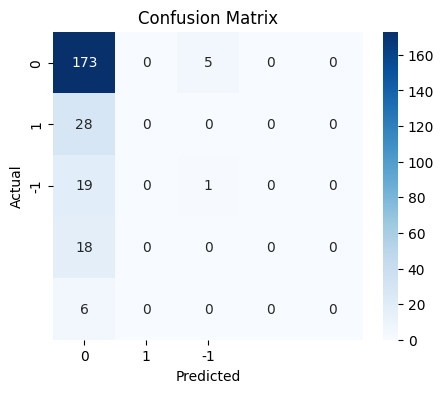

In [71]:
plot_confusion_matrix(base_wv,X_train_wv,y_train_wv)

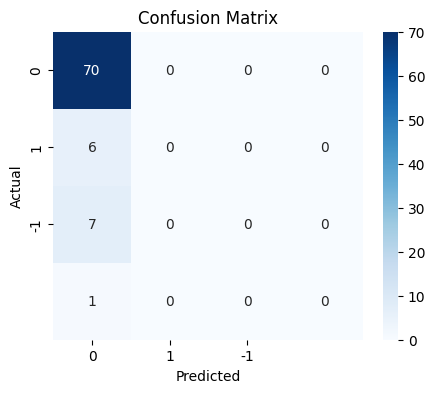

In [72]:
plot_confusion_matrix(base_wv,X_val_wv,y_val_wv)

In [73]:
# Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train_wv)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision        F1
0     0.696   0.696   0.518153  0.589926


In [74]:
# Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val_wv)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.833333  0.833333   0.694444  0.757576


### Tuned Model - Word2Vec

In [83]:
tuned_wv = AdaBoostClassifier(random_state=42)

parameters = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}
# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train_wv)



# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

In [84]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train_wv)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=500,
                   random_state=42)

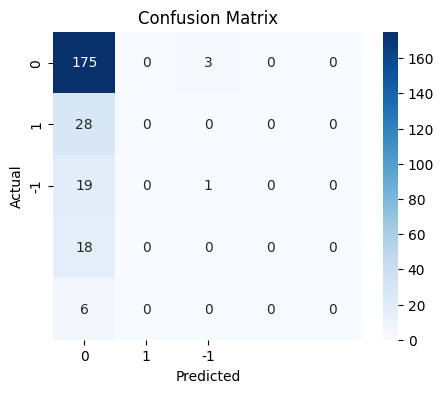

In [85]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train_wv)

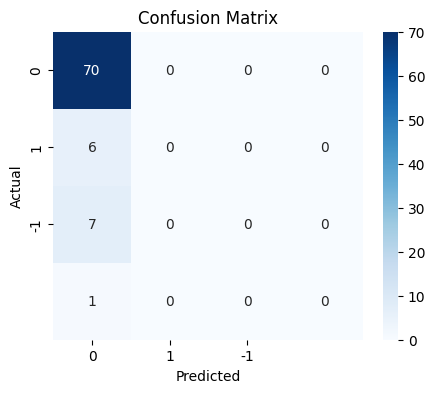

In [86]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val_wv)

In [87]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train_wv)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision        F1
0     0.704   0.704   0.526504  0.594403


In [88]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val_wv)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.833333  0.833333   0.694444  0.757576


In [89]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     tuned_train_wv.T
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Tuned Model (Word2Vec)",
  ]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Tuned Model (Word2Vec)
Accuracy,0.696000,0.704000
Recall,0.696000,0.704000
Precision,0.518153,0.526504
F1,0.589926,0.594403


In [90]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     tuned_val_wv.T
    ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Tuned Model (Word2Vec)"

]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Tuned Model (Word2Vec)
Accuracy,0.833333,0.833333
Recall,0.833333,0.833333
Precision,0.694444,0.694444
F1,0.757576,0.757576
